In [19]:
import numpy as np
import torch
import argparse
import json
import sys
from pathlib import Path
import _pickle as cPickle
import numpy as np
import torch.nn as nn
from natsort import natsorted
from torch import optim
from PIL import Image
from tqdm import tqdm
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import scipy.io as sio
from matplotlib.patches import Rectangle
import cv2
import matplotlib.image as img
import matplotlib.pyplot as plt
sys.path.append("modules/helpers")
sys.path.append("configs")
sys.path.append("common")

import robust_loss_pytorch.general
from configs.mv_nrsfm_configs import get_dictionary, get_seed
from modules.mvnrsfm.neural_prior_modules import (
    BlockSparseCodingLayer,
    CameraEstimator,
    OnPEstimator,
    SparseCodeExtractionLayer,
    VecSparseCodingLayer,
)
from util_cameras import normalize_3d_structure, procrustes_align
from util_common import get_device, make_dir, parse_boolean, extract_bone_connections, get_colors, load_datasets
from util_errors import computeMPJPE, error_ratio
from visualize import gen_predictions_with_confidence, gen_BBox_demo, get_figure3d


##### Choose between:
-  `visualize_only` or 
- `evaluate_visualize` (Coming Soon: Run inference code on your/provided data and then visualize)

In [76]:
type = 'visualize_only'
dataset = 'Flamingo'

##### Load the dataset.

In [77]:
""" Loading the dataset """
class ARGS:
  def __init__(self, dataset):
    self.dataset = dataset
    self.field_of_validation = "Predictions"
    self.MBW_Iteration = 6
    self.validate_manual_labels = False
    self.img_type=".jpg"

args = ARGS(dataset)
loaded_data, misc_data = load_datasets(args)

print("--- DATASET STATISTICS --- ")
print("Dataset loaded: {}".format(args.dataset))
print("Total views: {}".format(misc_data['total_views']))
print("Total frames: {}".format(misc_data['total_frames']))
print("# of joints: {}".format(misc_data['num_joints']))
print("Groundtruth available: ", misc_data['GT_Flag'])

--- DATASET STATISTICS --- 
Dataset loaded: Flamingo
Total views: 2
Total frames: 701
# of joints: 11
Groundtruth available:  False


##### Ask for frame numbers / views to visualize.

In [90]:
frame_to_visualize = 60           # Frame number to visualize
multi_views_visualize = True     # All views (side-by-side) visualzation or single view visualization
view_to_visualize = 0            # Only input view if you want separate visualizations for the view

##### 2D Joints and Bounding Boxes visualization

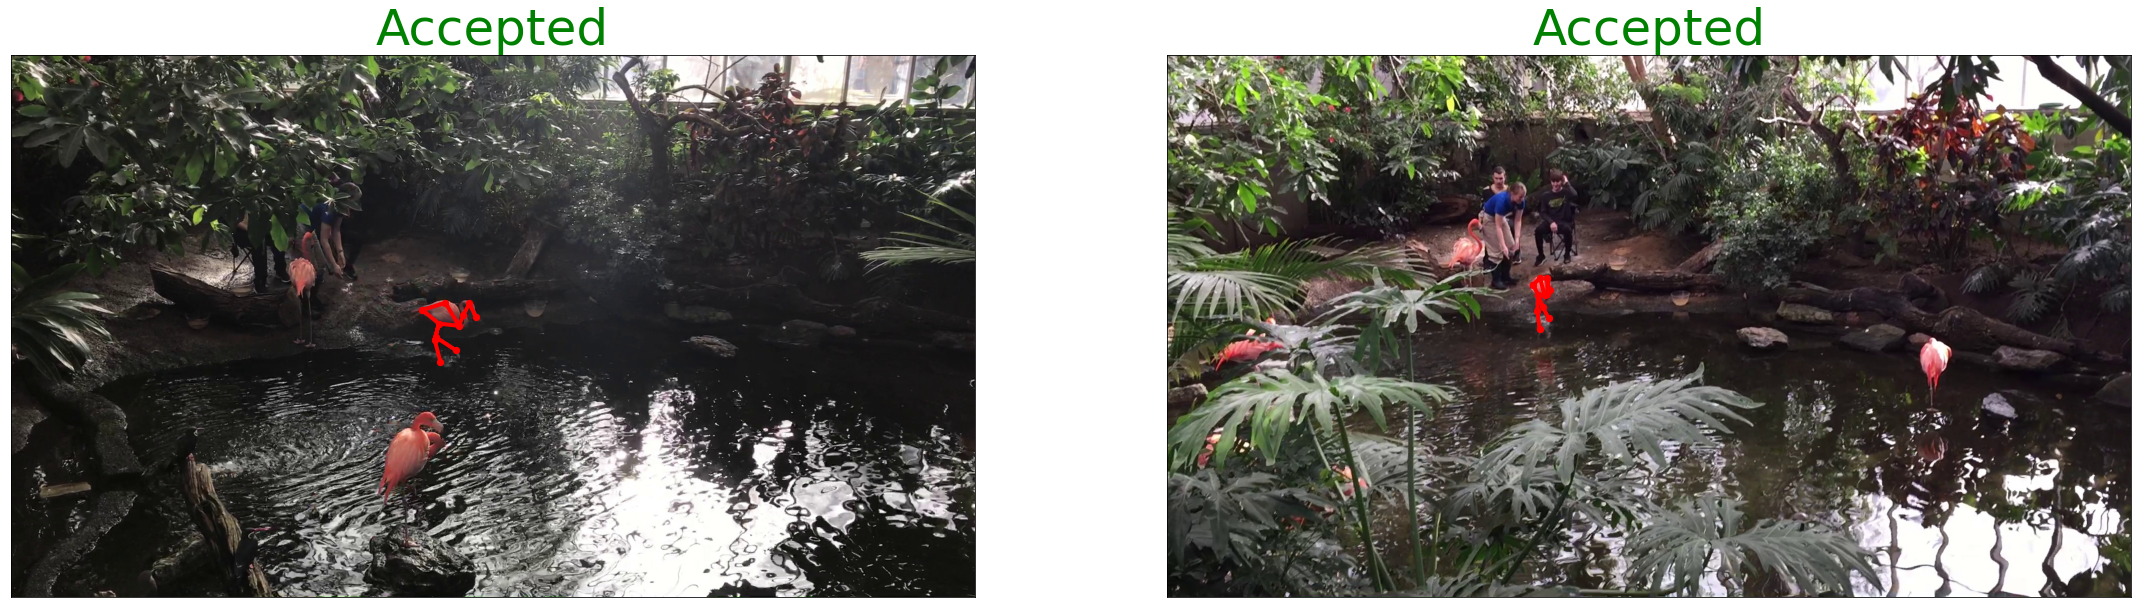

In [91]:
""" 2D Joints """
images = []
if multi_views_visualize:    
    for cam_idx in range(misc_data['total_views']):
        images.append(img.imread(misc_data['image_paths'][cam_idx][frame_to_visualize]))
else:
    images.append(img.imread(misc_data['image_paths'][view_to_visualize][frame_to_visualize]))

figure = gen_predictions_with_confidence(
    images,
    loaded_data['W_Pred'][:, frame_to_visualize, :, :],
    loaded_data['confidence'][:, frame_to_visualize],
    misc_data['joint_connections']
)

plt.show()
plt.cla()
plt.clf()
plt.close()



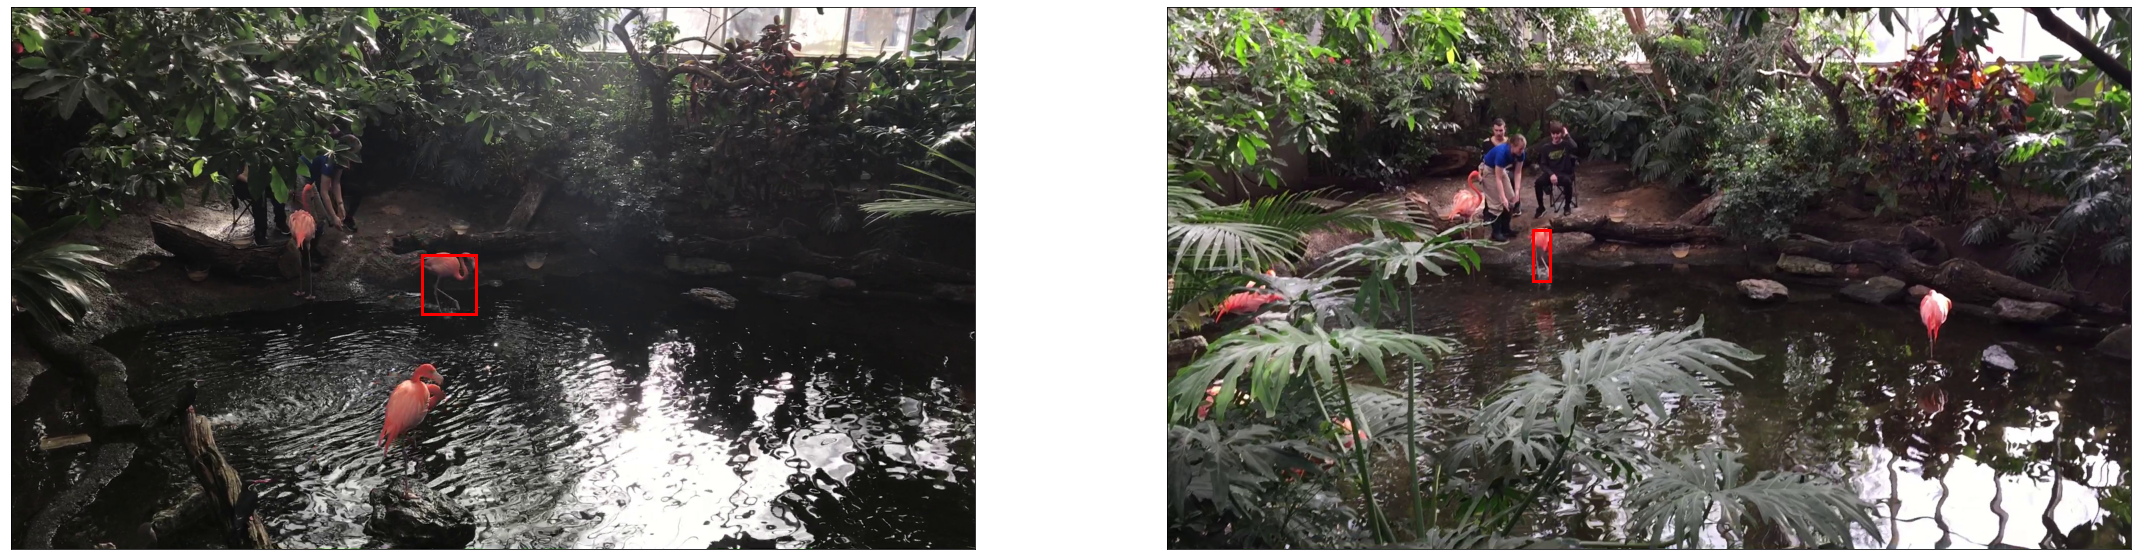

In [92]:
""" Bounding boxes """
figure = gen_BBox_demo(
    images,
    loaded_data['BBox'][:, frame_to_visualize, :],
    misc_data['joint_connections']
)
plt.show()
plt.cla()
plt.clf()
plt.close()

##### 3D Joints interactive visualization

In [94]:
""" 3D structure """
fig = get_figure3d(
    misc_data['joint_connections'],
    -1.7678,
    0.0,
    -loaded_data['S_Pred'][0,frame_to_visualize, :, :] @ misc_data['rigid_rotation'],
    range_scale=1.3,
)
# -1.7678 and 0 arguments corresponds to random camera placement in 3D space.
py.iplot(fig)
plt.cla()
plt.clf()
plt.close()
